# Notebook to explore the universe of alternative alphabets

Goal is to write a poem that will allow complementary base pairing: i.e. the key and query of a dictionary can be flipped and still allow for a valid sentence.

In [164]:
import numpy as np
import pandas as pd
import string
import os
import shutil
from timeit import timeit
import string
if not os.path.exists('words.txt'):
    !wget -q -O words.txt http://www.mieliestronk.com/corncob_lowercase.txt words.txt
#     !wget -q -o words.txt https://raw.githubusercontent.com/dwyl/english-words/master/words.txt

words = pd.read_csv('words.txt',sep='\n',header=None)[0]
words = words[words.notnull()].reset_index(None,True)

letters = [l for l in string.ascii_lowercase]
num_letters = np.arange(1,27)
di_num2let = dict(zip(num_letters, letters))
nletters = 26
# Function to generate paired mapping
def gen_mapping(seed, arr, n):
  np.random.seed(seed)
  return np.random.choice(arr, n, False).reshape([int(n/2),2])
#timeit('gen_mapping(2,num_letters, nletters)',globals=globals(),number=100000)

def alpha_trans(txt, xmap):
  s1 = ''.join(Xmap[:,0])
  s2 = ''.join(Xmap[:,1])
  trans = str.maketrans(s1+s2, s2+s1)
  return txt.str.translate(trans)

In [170]:
Xmap = gen_mapping(35577,letters, nletters)
di_map = dict(zip(Xmap[:,0], Xmap[:,1]))
txt = words.sample(13,random_state=1).copy()
trans = alpha_trans(txt, Xmap)
df_example = pd.concat([pd.DataFrame(Xmap,columns=['from','to']),
                        pd.DataFrame({'original':txt, 'mapped':trans}).reset_index(None,True)],1)
print(df_example)  #[['from','to']]

   from to     original       mapped
0     p  f  mineworkers  ckdobeliolt
1     n  d       desire       notklo
2     x  j       pickle       fkmiro
3     b  w      dassies      nuttkot
4     z  g     tartrate     sulsluso
5     q  y      airbase      uklwuto
6     t  s    heirlooms    voklreect
7     i  k        boron        weled
8     e  o   misprinted   cktflkdson
9     c  m      headmen      vouncod
10    r  l     enlarger     odrulzol
11    a  u      artwork      ulsbeli
12    h  v     merciful     colmkpar


In [85]:
from time import time

nsim = 80000
tnow = time()

holder = []
for ii in range(nsim):
    if (ii+1) % 10000 == 0:
        tdiff = time() - tnow
        print('Simulation %i of %i (took %i seconds)' % (ii+1, nsim, tdiff))
        tnow = time()
    # Generate a random mapping
    Xmap = gen_mapping(ii, letters, nletters)
    words = words[words.notnull()].reset_index(None,True)
    trans = alpha_trans(words.copy(), Xmap)
    idx = trans.isin(words)
    df = pd.DataFrame({'original':words[idx],'mapped':trans[idx],'seed':ii})
    holder.append(df)
dat_sim = pd.concat(holder).reset_index(None,True)

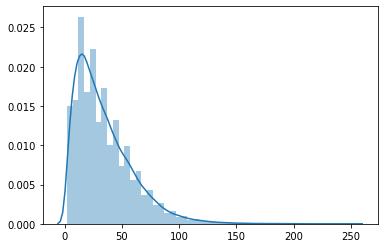

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(dat_sim.groupby('seed').size())

mx_idx = dat_sim.groupby('seed').size().sort_values(ascending=False).head(1).index[0]
pd.options.display.max_rows=260
dat_map = dat_sim[dat_sim.seed == mx_idx].reset_index(None,True).assign(ll = lambda x: x.mapped.str.len())
dat_map.sort_values('ll',ascending=False).head(15)

In [148]:
dat_map[['original']].to_csv('fewwords.txt',header=None,index=False,sep='\t')
fewwords = ','.join(dat_map.original).split(',')

In [137]:
!subword-nmt learn-bpe -s 10000 < fewwords.txt > vocab.bpe

no pair has frequency >= 2. Stopping


In [167]:
# dat_map.drop(columns=['seed','ll']).to_csv('mapping.csv',index=False)
# dat_map.head()

In [150]:
# !git clone https://github.com/graykode/gpt-2-Pytorch
# %cd gpt-2-Pytorch
# !curl --output gpt2-pytorch_model.bin https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin
# !pip install -r requirements.txt
path_bpe = os.path.join('gpt-2-Pytorch','GPT2','vocab.bpe')
path_json = os.path.join('gpt-2-Pytorch','GPT2','encoder.json')
# shutil.copyfile(path_bpe, os.path.join('gpt-2-Pytorch','GPT2','vocab_backup.bpe'))
# shutil.copyfile(path_json, os.path.join('gpt-2-Pytorch','GPT2','encoder_backup.json'))
# shutil.copyfile(os.path.join('gpt-2-Pytorch','GPT2','vocab_backup.bpe'), path_bpe)
shutil.copyfile(os.path.join('gpt-2-Pytorch','GPT2','encoder_backup.json'), path_json)

# df = pd.read_csv(path_bpe,header=None,sep='\n',error_bad_lines=False)
# print(df.shape)
# df = df[0][~df[0].str.contains('[^Ġa-z\\s]')].reset_index(None,True)
# df.to_csv(path_bpe, sep='\n', index=False, header=None)
import json
with open(path_json) as f:
  di_vocab = json.load(f)
# Add on
punct = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/','Ġ']
letters = [z for z in string.ascii_letters]
others = ['en', 'Ġen']
new_words = punct + ['Ġ'+z for z in words] + fewwords + letters + others
words_json = pd.Series(list(di_vocab))
wmatch = words_json[words_json.isin(new_words)].to_list()
print(di_vocab['Ġten'])
di_new = { z: di_vocab[z] for z in wmatch }
with open(path_json, 'w') as outfile:
    json.dump(di_new, outfile)

3478


In [154]:
# !pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html


!python ./gpt-2-Pytorch/main.py --quiet True --text "at ten" --length 5

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp-7c85b1e2.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
